<a href="https://colab.research.google.com/github/cuongquoc97/Trading_Random_Forest/blob/main/Trading_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# include thư viện :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
df.head()

Saving FPT.csv to FPT.csv


,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


In [ ]:
# Chuyển đổi Date/Time từ mỗi phút gộp thành mỗi ngày :
# Open : là giá cổ phiếu lúc mở phiên giao dịch đầu tiên
# Close : là giá mở phiên cuối ngày
# High : là giá cao nhất của ngày hôm đó
# Low : là giá thấp nhất của ngày hôm đó
# Volumn : là tổng lượng giao dịch của ngày hôm đó

df['Date/Time'] = pd.to_datetime(df['Date/Time']) # Chuyển Date/Time thành id
df = df.set_index('Date/Time')

# Chuyển phút thành ngày , gộp những cột thành 1 ngày :
df_daily = df.resample('D').agg({
    'Open':'first',
    'High':'max',
    'Low' :'min',
    'Close':'last',
    'Volume':'sum'
}).dropna()
df_daily.head()

,Open,High,Low,Close,Volume
Date/Time,,,,,
2018-12-25,30.89,30.89,30.59,30.66,84960
2018-12-26,31.04,31.22,30.89,30.89,333590
2018-12-27,31.41,31.52,31.19,31.19,454860
2018-12-28,31.34,31.49,31.19,31.49,387170
2019-01-02,31.19,31.45,30.70,30.74,459120


Bước 2 : Train mô hình Random Forest để dự đoán giá cổ phiếu ngày mai :

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Tạo cột giá ngày mai để làm nhãn :
df_daily['Target'] = df_daily['Close'].shift(-1)
df_daily = df_daily.dropna()  # Xóa hàng NaN

# Chia dữ liệu train/test
features = ['Open', 'High', 'Low', 'Close', 'Volume']
X = df_daily[features]
y = df_daily['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train mô hình Random Forest
model = RandomForestRegressor(n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

MSE: 8.38
R² Score: 0.13


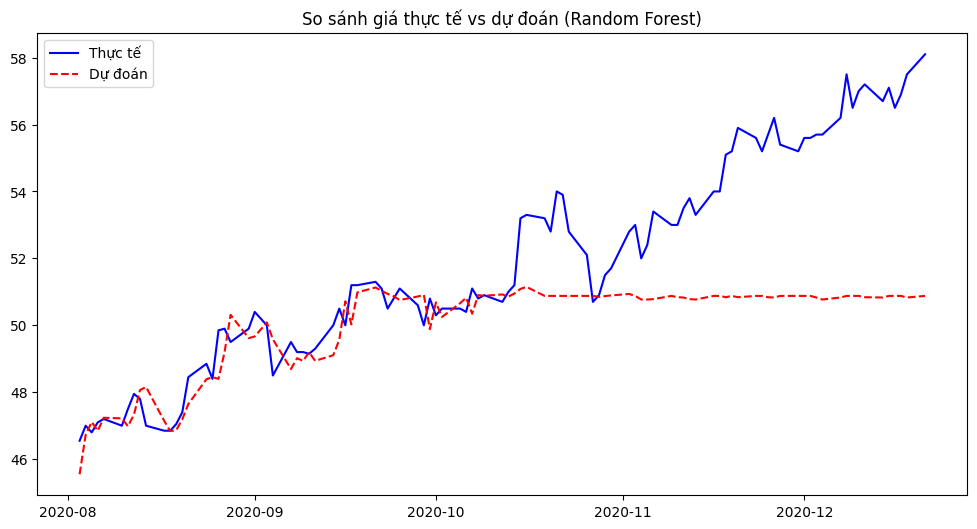

In [ ]:
# Bước 3 kiểm tra dự đoán và vẽ biểu đồ :
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Thực tế", color='blue')
plt.plot(y_test.index, y_pred, label="Dự đoán", color='red', linestyle='dashed')
plt.legend()
plt.title("So sánh giá thực tế vs dự đoán (Random Forest)")
plt.show()

In [ ]:
df_daily.head()

,Open,High,Low,Close,Volume,Target
Date/Time,,,,,,
2018-12-25,30.89,30.89,30.59,30.66,84960,30.89
2018-12-26,31.04,31.22,30.89,30.89,333590,31.19
2018-12-27,31.41,31.52,31.19,31.19,454860,31.49
2018-12-28,31.34,31.49,31.19,31.49,387170,30.74
2019-01-02,31.19,31.45,30.70,30.74,459120,30.44


In [ ]:
# Dự đoán dữ liệu cổ phiếu ngày mới nhất :
# Lấy dữ liệu của ngày cuối cùng để dự đoán ngày tiếp theo
latest_data = df_daily.iloc[-1][['Open', 'High', 'Low', 'Close', 'Volume']].values.reshape(1, -1)

# Dự đoán giá Close của ngày mai
predicted_price = model.predict(latest_data)[0]

print(f"🔮 Dự đoán giá Close ngày mai: {predicted_price:.2f}")

🔮 Dự đoán giá Close ngày mai: 50.88


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# Đưa ra dự đoán là có nên mua hay không ?
# Tính phần trăm thay đổi so với giá Close hiện tại
current_close = df_daily.iloc[-1]['Close']
change_percent = (predicted_price - current_close) / current_close * 100

# Quy tắc giao dịch
if change_percent > 1:
    action = "Buy 📈"
elif change_percent < -1:
    action = "Sell 📉"
else:
    action = "Hold 🤔"

print(f"🔮 Dự đoán giá ngày mai: {predicted_price:.2f} | Hiện tại: {current_close:.2f} | Biến động: {change_percent:.2f}%")
print(f"🚀 Khuyến nghị: {action}")

🔮 Dự đoán giá ngày mai: 50.88 | Hiện tại: 57.50 | Biến động: -11.51%
🚀 Khuyến nghị: Sell 📉
